In [1]:
#For colab
!pip install \
'git+https://github.com/facebookresearch/segment-anything.git'
!pip install -q roboflow supervision
!wget -q \
'https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth'
#'https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth'

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-599b1ij8
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-599b1ij8
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done


In [2]:
import torch
from segment_anything import SamPredictor, sam_model_registry

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"

sam = sam_model_registry[MODEL_TYPE](checkpoint="sam_vit_h_4b8939.pth")
sam.to(DEVICE)

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-31): 32 x Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=1280, out_features=5120, bias=True)
          (lin2): Linear(in_features=5120, out_features=1280, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(1280, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d

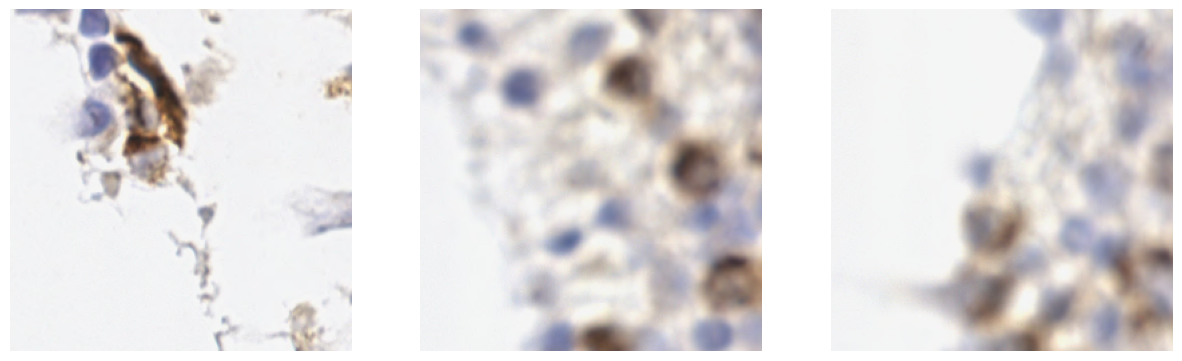

In [3]:
from PIL import Image
import os
import cv2
from matplotlib import pyplot as plt

images = []
images_names = []
for file in os.listdir("."):
    if file.endswith(".png"):
        images_names.append(str(file))
        image_bgr = cv2.imread(os.path.join("./", file))
        image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
        images.append(image_rgb)

import random
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i in range(3):
    rand_num = random.randint(0, len(images)-1)
    axs[i].imshow(np.array(images[rand_num]))
    axs[i].axis("off")

In [4]:
def draw_masks_fromDict(image, masks_generated) :
  masked_image = image.copy()
  for i in range(len(masks_generated)) :
    masked_image = np.where(np.repeat(masks_generated[i]['segmentation'].astype(int)[:, :, np.newaxis], 3, axis=2),
                            np.random.choice(range(256), size=3),
                            masked_image)

    masked_image = masked_image.astype(np.uint8)

  return cv2.addWeighted(image, 0.3, masked_image, 0.7, 0)

In [5]:
def preprocessing(image):
  image_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
  ret, image_tresh = cv2.threshold(image_gray, 180 , 255, cv2.THRESH_BINARY)
  contours, _ = cv2.findContours(image_tresh, cv2.RETR_LIST , cv2.CHAIN_APPROX_NONE)
  region_centers = []
  for contour in contours:
      M = cv2.moments(contour)
      # Calculate the center coordinates of the contour
      if M["m00"] == 0:
          continue
      cX = int(M["m10"] / M["m00"])
      cY = int(M["m01"] / M["m00"])

      # Append the center coordinates to the list
      region_centers.append([cX, cY])
  labels = np.array([1]*len(region_centers))
  return np.array(region_centers), labels

In [6]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

In [7]:
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

<function matplotlib.pyplot.show(close=None, block=None)>

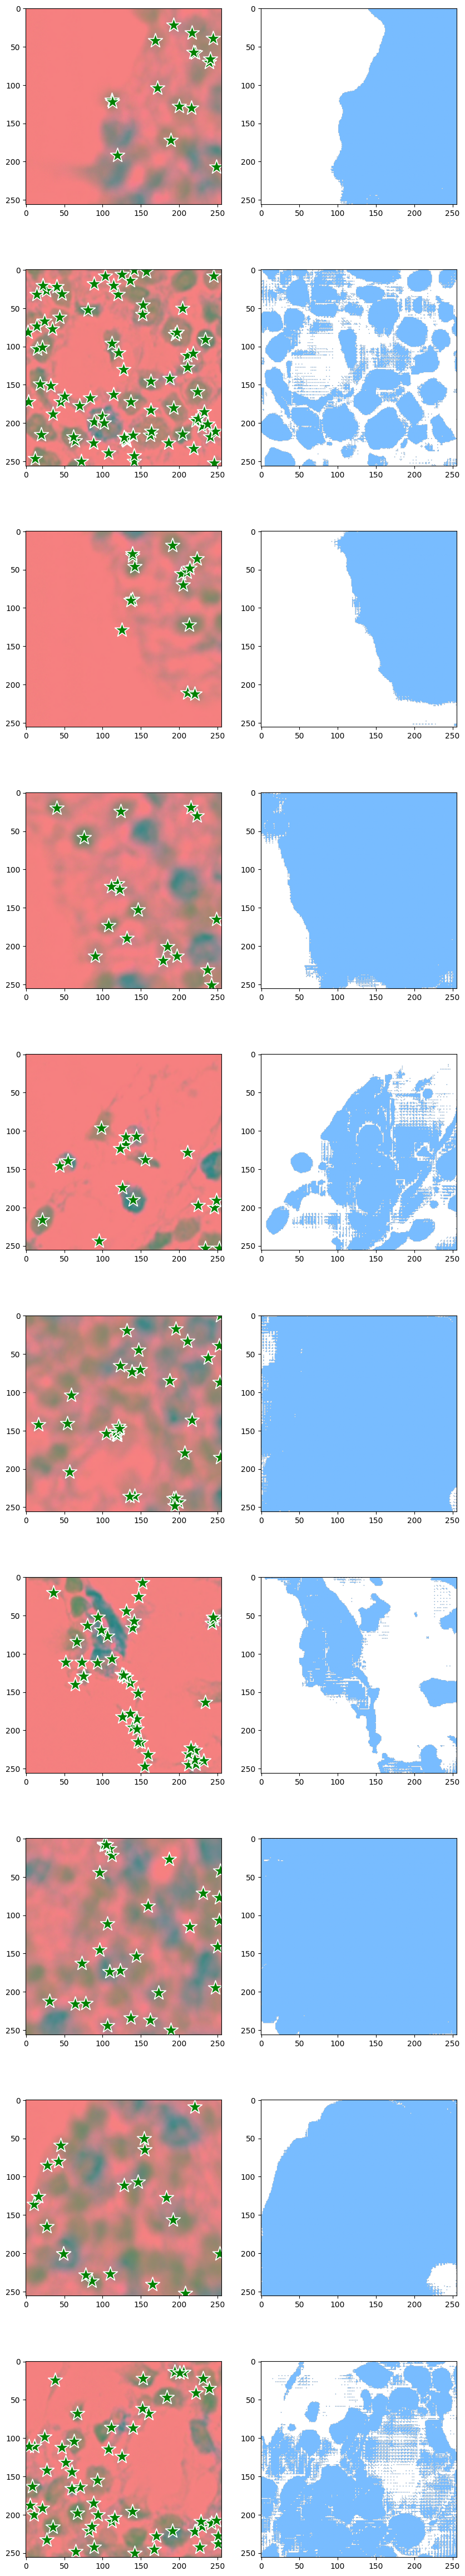

In [9]:
from segment_anything import SamPredictor

predictor = SamPredictor(sam)

fig, axis = plt.subplots(len(images),2,figsize=(10,60))
for i,img in enumerate(images):
  coords,labels = preprocessing(img)
  show_points(coords,labels,axis[i][0])
  img_lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
  predictor.set_image(img_lab)
  axis[i][0].imshow(img_lab)
  masks,_,_ = predictor.predict(multimask_output=False, point_coords=coords, point_labels=labels)
  show_mask(masks,axis[i][1])
  #axis[i][1].imshow(segmented_image, cmap='gray')
plt.show